## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras  import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import OneHotEncoder

## Download dữ liệu phân bón từ google drive về

In [ ]:
!gdown --id 1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
!gdown --id 1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
To: /content/chemical_analysis.xlsx
100% 56.2k/56.2k [00:00<00:00, 71.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED
To: /content/spectra.xlsx
100% 4.38M/4.38M [00:00<00:00, 23.6MB/s]


In [ ]:
chemical_df = pd.read_excel('/content/chemical_analysis.xlsx')
spectral_df = pd.read_excel('/content/spectra.xlsx')

## Tổng hợp thông tin giữa 2 bảng

In [ ]:
spectra_data = spectral_df.iloc[:, 1:]
classes = chemical_df['Manure_type']
data = pd.concat([classes, spectra_data], axis=1)
spectra_data = data.iloc[:, 1:]

## Preprocessing

### Mã hóa Label

In [ ]:
Class = data[['Manure_type']].values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(Class)
encoder = OneHotEncoder(categories='auto')
encoded_classes = encoder.fit_transform(encoded_classes.reshape(-1, 1)).toarray()
print(encoded_classes.shape)

(490, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Số mẫu: ",spectra_data.shape[0])
print("Số chiều vector phổ NIR: ",spectra_data.shape[1])

Số mẫu:  490
Số chiều vector phổ NIR:  1003


### Làm mượt dữ liệu bằng Savitzky-Golay filter

In [ ]:
spectra_data_cleaned = spectra_data.copy()
spectra_data_cleaned.iloc[:, 1:] = spectra_data_cleaned.iloc[:, 1:].apply(lambda x: x.str.replace(',', '.', regex=True))
spectra_data_cleaned = spectra_data_cleaned.iloc[:, 1:].astype('float64')
# spectra_data_smoothed = spectra_data_cleaned.apply(lambda x: savgol_filter(x, 21, 3), axis=0)

### Chuẩn hóa dữ liệu bằng SNV

In [ ]:
scaler = StandardScaler()
Spectra_data = scaler.fit_transform(spectra_data_cleaned)

## Mô hình Vision Transformer

In [ ]:
def convert_to_pseudo_image(Spectra_data):
  Spectra_data = tf.convert_to_tensor(Spectra_data)
  Spectra_data= tf.expand_dims(Spectra_data,axis=2)
  Spectra_data = tf.expand_dims(Spectra_data,axis=3)
  Spectra_data = tf.reshape(Spectra_data[:,0:968],(Spectra_data.shape[0],22,22,2))
  return Spectra_data

In [ ]:
X_train = convert_to_pseudo_image(X_train)
X_test = convert_to_pseudo_image(X_test)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (343, 22, 22, 2)
X_test shape: (147, 22, 22, 2)
y_train shape: (343, 6)
y_test shape: (147, 6)


In [ ]:
def PatchEmbedding(x):
  B, H, W, C = x.shape
  x = layers.Conv2D(64, kernel_size=8, strides=1)(x)
  x = tf.reshape(x, [-1, 16, 64])
  return x

In [ ]:
import tensorflow as tf

def VisionTransformer():
  inputs = Input(shape=(22, 22, 2))
  x = inputs
  B, H, W , C = x.shape

  x1 = x[:, :H // 2, :W // 2,:]
  x2 = x[:, H // 2:, :W // 2,:]
  x3 = x[:, :H // 2, W // 2:,:]
  x4 = x[:, H // 2:, W // 2:,:]

  x1 = PatchEmbedding(x1)
  x2 = PatchEmbedding(x2)
  x3 = PatchEmbedding(x3)
  x4 = PatchEmbedding(x4)

  x = tf.concat([x1, x2, x3, x4], axis=1)

  x_skip = x
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x,x,x,x)
  x = tf.add(x_skip,x)
  x_skip = x
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = tf.add(x_skip,x)

  x = tf.reduce_mean(x, axis=1)
  x = layers.Dense(6 , activation='softmax')(x)
  model = Model(inputs=inputs, outputs=x)
  return model


In [ ]:
model = VisionTransformer()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(), metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 4s 40ms/step - loss: 1.4204 - accuracy: 0.6181 - val_loss: 1.2652 - val_accuracy: 0.6735
Epoch 2/500
11/11 [==============================] - 0s 16ms/step - loss: 1.0909 - accuracy: 0.7318 - val_loss: 1.1444 - val_accuracy: 0.6871
Epoch 3/500
11/11 [==============================] - 0s 13ms/step - loss: 1.0226 - accuracy: 0.7172 - val_loss: 1.0482 - val_accuracy: 0.6939
Epoch 4/500
11/11 [==============================] - 0s 13ms/step - loss: 0.9604 - accuracy: 0.7201 - val_loss: 1.0004 - val_accuracy: 0.6871
Epoch 5/500
11/11 [==============================] - 0s 12ms/step - loss: 0.9056 - accuracy: 0.7289 - val_loss: 0.9602 - val_accuracy: 0.7007
Epoch 6/500
11/11 [==============================] - 0s 12ms/step - loss: 0.8736 - accuracy: 0.7259 - val_loss: 0.9534 - val_accuracy: 0.6939
Epoch 7/500
11/11 [==============================] - 0s 13ms/step - loss: 0.8500 - accuracy: 0.7376 - val_loss: 0.9389 - val_accuracy: 0.7007
Epoch 

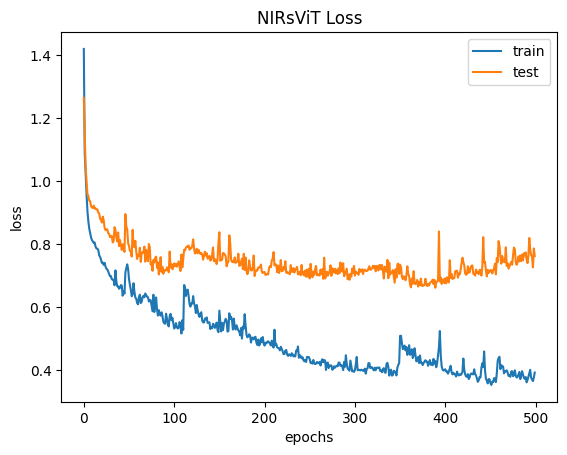

<Figure size 800x1300 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('NIRsViT Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

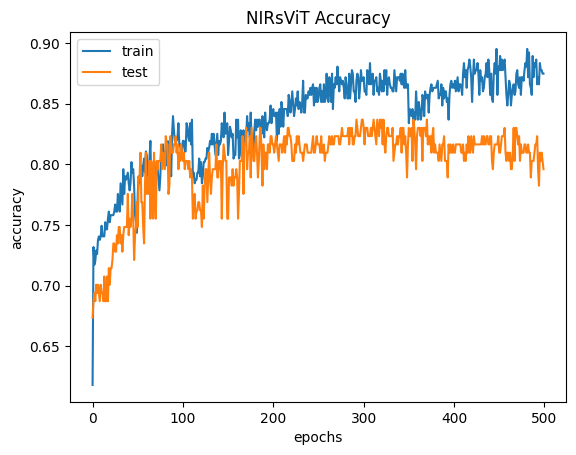

<Figure size 800x1300 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('NIRsViT Accuracy')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.7959183673469388
F1_Score:  0.3741653826399589
Precision:  0.43829787234042555
Recall:  0.35866138974502665


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save_weights('NIRsViT.h5')